In [1]:
# Run some setup code for this notebook.

import random
import numpy as np
from asgn1.cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
import DataUtils as du
X_train, y_train, P_train, X_val, y_val, P_val, X_test, y_test, P_test = du.loadData()

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (18927, 32, 32, 3)
Train labels shape:  (18927,)
Validation data shape:  (5375, 32, 32, 3)
Validation labels shape:  (5375,)
Test data shape:  (2682, 32, 32, 3)
Test labels shape:  (2682,)


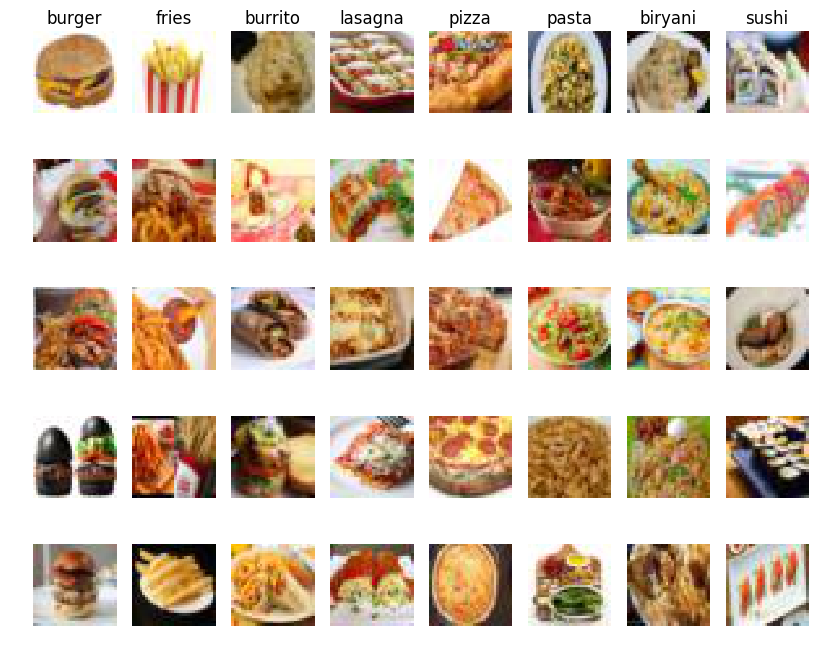

In [3]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['burger', 'fries', 'burrito', 'lasagna', 'pizza', 'pasta', 'biryani', 'sushi']
num_classes = len(classes)
samples_per_class = 5
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)

#plt.savefig('assets/1_data_vis.png')
plt.show()

In [4]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)

Training data shape:  (18927, 3072)
Validation data shape:  (5375, 3072)
Test data shape:  (2682, 3072)


[ 152.49960374  139.56469594  127.47429598  153.88349976  140.68299255
  128.29439425  155.10249908  141.58461457  128.81085222  156.33417869]


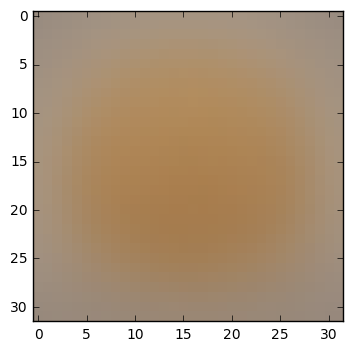

In [5]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

In [6]:
mean_image.dtype

dtype('float64')

In [7]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image

In [8]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape)

(18927, 3073) (5375, 3073) (2682, 3073)


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [9]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from asgn1.cs231n.classifiers import LinearSVM
import time

svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 1580.296724
iteration 100 / 1500: loss 578.233001
iteration 200 / 1500: loss 219.898146
iteration 300 / 1500: loss 87.514771
iteration 400 / 1500: loss 41.941635
iteration 500 / 1500: loss 22.023951
iteration 600 / 1500: loss 16.347574
iteration 700 / 1500: loss 14.583598
iteration 800 / 1500: loss 13.535621
iteration 900 / 1500: loss 12.507105
iteration 1000 / 1500: loss 12.900448
iteration 1100 / 1500: loss 13.212564
iteration 1200 / 1500: loss 13.180368
iteration 1300 / 1500: loss 13.652593
iteration 1400 / 1500: loss 14.316043
That took 14.897901s


In [10]:
svm.W.shape

(3073, 20)

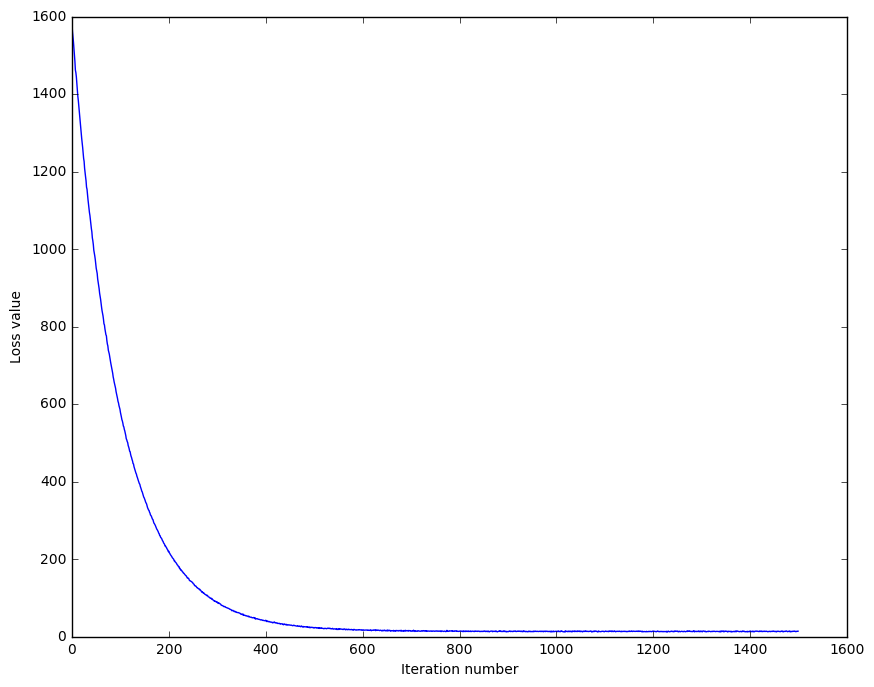

In [11]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [12]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.207059
validation accuracy: 0.186047


In [13]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.
#learning_rates = [1e-7, 5e-5]
#regularization_strengths = [2.5e4, 5e4]

learning_rates = [1e-8, 1e-7, 1e-6]
regularization_strengths = [2.5e3, 2.5e4, 2.5e5]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################
#pass

for _l in learning_rates:
    for _r in regularization_strengths:
        svm = LinearSVM()
        loss_hist = svm.train(X_train, y_train, learning_rate=_l, reg=_r,
                      num_iters=1500, verbose=False)
                
        y_train_pred = svm.predict(X_train)
        train_accuracy = np.mean(y_train == y_train_pred)
        print('training accuracy: {0}'.format(train_accuracy))
        
        y_val_pred = svm.predict(X_val)
        val_accuracy = np.mean(y_val == y_val_pred)
        print('validation accuracy: {0}'.format(val_accuracy))

        results[(_l, _r)] = (train_accuracy, val_accuracy)
        if (val_accuracy > best_val):
            best_val = val_accuracy
            best_svm = svm

################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

training accuracy: 0.09346436307919903
validation accuracy: 0.08781395348837209
training accuracy: 0.11565488455645374
validation accuracy: 0.12372093023255815
training accuracy: 0.16938764727637767
validation accuracy: 0.1652093023255814
training accuracy: 0.19004596608020288
validation accuracy: 0.1681860465116279
training accuracy: 0.20573783483911873
validation accuracy: 0.1838139534883721
training accuracy: 0.16008876208590903
validation accuracy: 0.1570232558139535
training accuracy: 0.17002166217572778
validation accuracy: 0.141953488372093
training accuracy: 0.1291277011676441
validation accuracy: 0.12204651162790697
training accuracy: 0.08807523643472288
validation accuracy: 0.09041860465116279
lr 1.000000e-08 reg 2.500000e+03 train accuracy: 0.093464 val accuracy: 0.087814
lr 1.000000e-08 reg 2.500000e+04 train accuracy: 0.115655 val accuracy: 0.123721
lr 1.000000e-08 reg 2.500000e+05 train accuracy: 0.169388 val accuracy: 0.165209
lr 1.000000e-07 reg 2.500000e+03 train accur

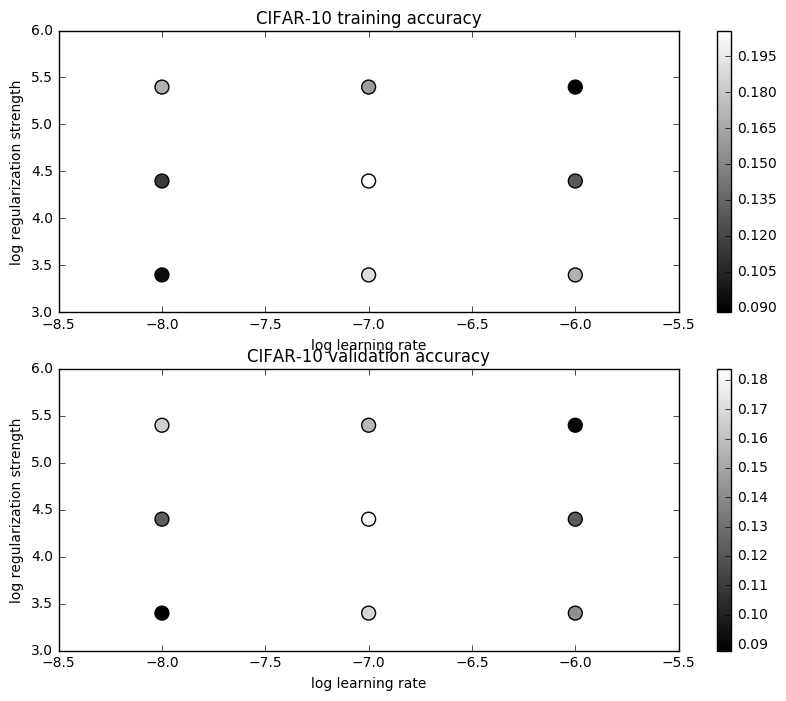

In [14]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [15]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.162192


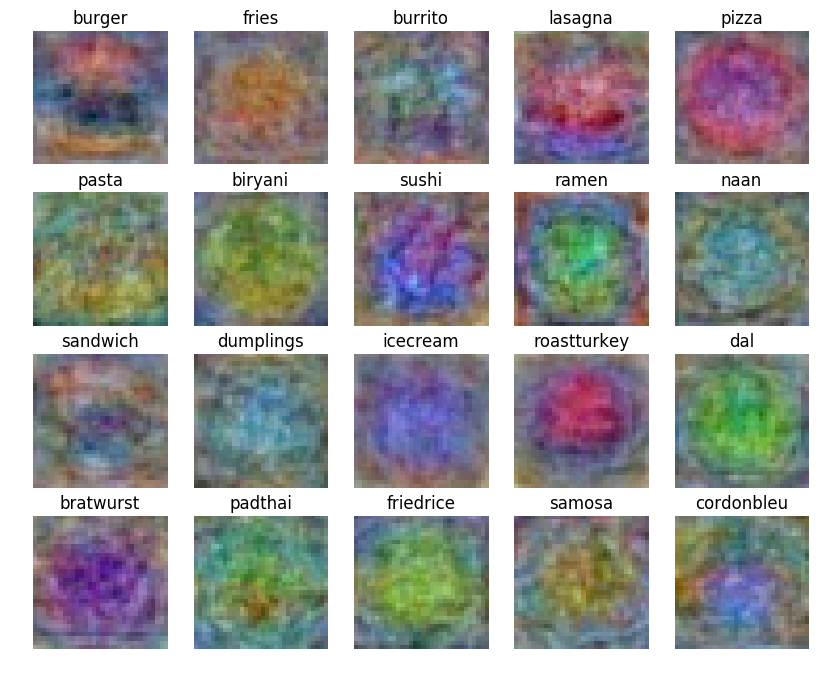

In [17]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 20)
w_min, w_max = np.min(w), np.max(w)
classes = ["burger","fries","burrito","lasagna","pizza","pasta","biryani","sushi","ramen","naan","sandwich","dumplings","icecream",
"roastturkey","dal","bratwurst","padthai","friedrice","samosa","cordonbleu"]

for i in range(20):
    plt.subplot(4, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])
    
#plt.savefig('assets/2_data_vis_svm_learned_weights.png')
plt.show()

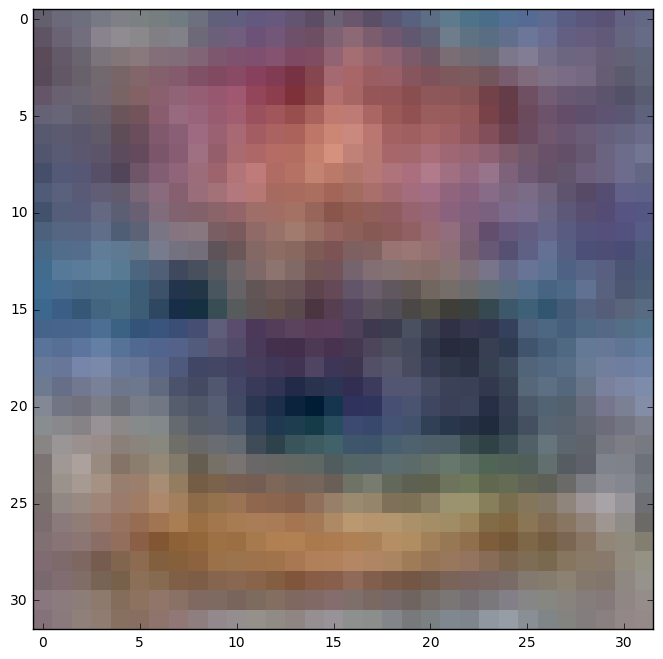

In [23]:
# Visualize the learned weights for burger
wimg = 255.0 * (w[:, :, :, 0].squeeze() - w_min) / (w_max - w_min)
plt.imshow(wimg.astype('uint8'))
plt.savefig('assets/svm_learnedweights_burger.png')
plt.show()

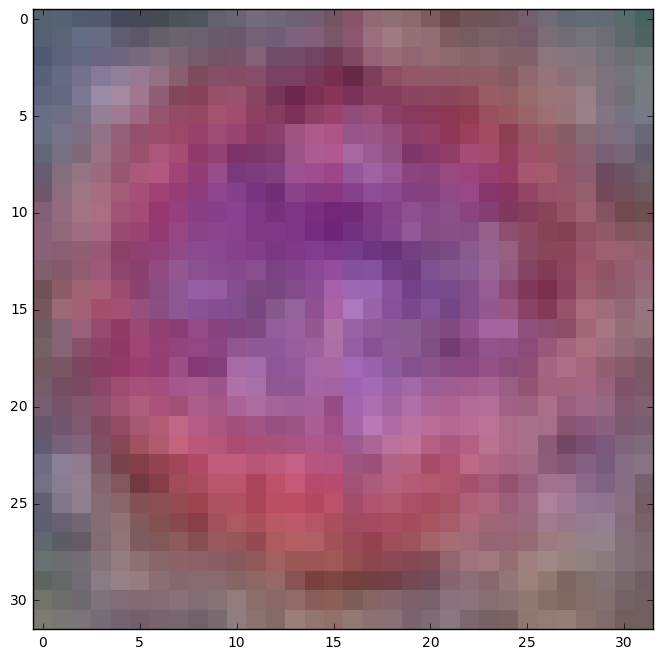

In [22]:
# Visualize the learned weights for burger
wimg = 255.0 * (w[:, :, :, 4].squeeze() - w_min) / (w_max - w_min)
plt.imshow(wimg.astype('uint8'))
plt.savefig('assets/svm_learnedweights_pizza.png')
plt.show()